In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from scipy import stats

In [2]:
data_path = '../../data/tfidf_toprev_conlen_fulldata/'

In [3]:
fandom_list = [i for i in os.listdir(data_path) if 'tsv' in i]

In [4]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

## Aggregate

In [15]:
def create_normed_dfs(df):
    
    # Normalize effects of authors by turning kudos into z-score corresponding to works from this author
    # Seems not useful b/c many authors only have 1 work
#     author_list = df.Author.drop_duplicates().tolist()
#     combined = []
#     for author in author_list:
#         df_a = df[df.Author == author]
#         if len(df_a) > 1:
#             df_a['Kudos'] = (df_a['Kudos'] - df_a['Kudos'].mean())/df_a['Kudos'].std(ddof=0)
#             combined.append(df_a)        
#     df = pd.concat(combined)
#     df = df[df.Kudos != 0]

# #     Normalize by creating hits/kudos 
#     df = df[df.Hits != 0]
#     df = df[df.Kudos != 0]
#     df['Kudos/Hits'] = df['Kudos'].astype(float)/df['Hits'].astype(float)
    
#     Normalize by log scale
#     df = df[df.Kudos != 0]
#     df['Kudos'] = np.log(df['Kudos'])
#     df = df[df.Hits != 0]
#     df['Hits'] = np.log(df['Hits'])
#     df['Kudos/Hits'] = df['Kudos'] - df['Hits']

#     # filter 0s
# #     df = df.fillna(0)"

#     # turn into z scores
#     df['Hits'] = df['Hits']/df['Chapters']
#     df = df.dropna(subset=['Hits'])
#     df = df[np.isfinite(df['Hits'])]
#     df['Hits'] = (df['Hits'] - df['Hits'].mean())/df['Hits'].std(ddof=0)
    
    df = df.dropna(subset=['Bookmarks'])
    df = df[np.isfinite(df['Bookmarks'])]
    df['Bookmarks'] = (df['Bookmarks'] - df['Bookmarks'].mean())/df['Bookmarks'].std(ddof=0)

    return df

In [16]:
def create_dict(df, field, binsize):
    
    # Make bins
    df.Cos = df.Cos.astype(float)
    min_cos = min(df.Cos.tolist())
    max_cos = max(df.Cos.tolist())
    dic = {}
    for i in np.arange(min_cos, max_cos, binsize):
        df_s = df[(df.Cos >= i) & (df.Cos < i+binsize)]
#         if len(df_s) > 9:
#             print (min_cos, max_cos)
#             print(df_s[field].tolist())
        li = df_s[field].tolist()
        if len(li) > 0:
            dic[i] = bootstrap_resample(li)
    return dic

In [17]:
def plot_agg(flist, title):
    df_all = []
    for i,fandom in enumerate(flist):
        df = pd.read_csv(os.path.join(data_path,fandom), sep = '\t')
        df = create_normed_dfs(df)
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df[['Cos', 'Bookmarks']].dropna()
        df_all.append(df)
        
    df = pd.concat(df_all)
    df = df.sort_values(by = 'Cos')[5:-5]
    df = df.sort_values(by = 'Bookmarks')[5:-5]
    dic = create_dict(df, 'Bookmarks', 0.1)
    x = sorted(dic.keys())
    y = [dic[j][0] for j in x]
    
    print(dic)
    
    #     Make error bars
    lower_error = [dic[j][0]-dic[j][1] for j in x]
    upper_error = [dic[j][2]-dic[j][0] for j in x]
    asymmetric_error = [lower_error, upper_error]



    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.xlabel('Novelty',fontsize=15)
    plt.ylabel('Bookmarks (z-score)',fontsize=15)

    plt.errorbar(x, y, yerr=asymmetric_error,fmt='o')
    plt.scatter(x, y)
    plt.title(title)
    

In [19]:
lda_kudos_dict = {0.3183411357554178: (0.24241465042484875, -0.006164701759626134, 0.5944718796431884), 0.36834113575541777: (0.22673578073694903, 0.15390811153868425, 0.30398280703288255), 0.41834113575541776: (0.14370523271634691, 0.12231307608458984, 0.16592279293653225), 0.46834113575541775: (0.09697002741735164, 0.08754993897590656, 0.10716537785241802), 0.5183411357554177: (0.05028840368030578, 0.04462646819885872, 0.05582556567387392), 0.5683411357554178: (-0.010889868000214827, -0.014638593609687596, -0.007197468435968111), 0.6183411357554177: (-0.03850769421516654, -0.041846794112008416, -0.035295115928653975), 0.6683411357554176: (0.03276530976037038, 0.0003204398026430979, 0.06694657868733242)}

lda_hits_dict = {0.3183411357554178: (0.27884664792988195, 0.062013599799952, 0.5562382779773377), 0.36834113575541777: (0.2562981864206463, 0.17230231474235036, 0.3610559775003062), 0.41834113575541776: (0.13551915361130698, 0.1131497680571293, 0.1579761596175224), 0.46834113575541775: (0.08365995415716668, 0.07449243031006982, 0.09300380521473733), 0.5183411357554177: (0.04492043088217013, 0.03925300301881276, 0.05111434760348703), 0.5683411357554178: (-0.013141202425299434, -0.01688417787813126, -0.009661719096339809), 0.6183411357554177: (-0.03204962726133093, -0.035502276486248194, -0.02881410270548949), 0.6683411357554176: (0.07688436256646546, 0.046927304461759675, 0.11002984965858927)}

lda_comments_dict = {0.3183411357554178: (0.3709164015739399, 0.0628434918740461, 0.7478274690899211), 0.36834113575541777: (0.1537689867883697, 0.09132066300370886, 0.2201660328650448), 0.41834113575541776: (0.16133050829963713, 0.1402098324782858, 0.1856482577194803), 0.46834113575541775: (0.12170781513884785, 0.11084342001054667, 0.13236151010537717), 0.5183411357554177: (0.05836731994653249, 0.0525201641585733, 0.0641749266904189), 0.5683411357554178: (-0.007873190649432165, -0.011737002270966657, -0.004064747082960769), 0.6183411357554177: (-0.045159492748748684, -0.04872082308623657, -0.04179512210024448), 0.6683411357554176: (-0.055276716304541604, -0.0796936951883854, -0.028728872134709114)}

lda_bookmarks_dict = {0.3183411357554178: (0.29233516568034834, 0.024238078285889583, 0.617133573448504), 0.36834113575541777: (0.2871806661664359, 0.21008469302514796, 0.37104403487104076), 0.41834113575541776: (0.17699276742209707, 0.15518255359572267, 0.19965909287131772), 0.46834113575541775: (0.11789009689218069, 0.1080408608503596, 0.12777511799579122), 0.5183411357554177: (0.058592390698911964, 0.052530374342019015, 0.06505624733416811), 0.5683411357554178: (-0.011680729350875715, -0.015460974072291725, -0.007845392013090464), 0.6183411357554177: (-0.044977810722696986, -0.04826990918771911, -0.041521476033411116), 0.6683411357554176: (0.025720876302607262, -0.0023433014211147432, 0.05321990647970966)}

tfidf_kudos_dict = {0.07306596877841331: (0.10051092067956448, 0.09230688109665527, 0.10949622538494314), 0.17306596877841332: (0.06278218097722164, 0.057723352384369396, 0.06815467678199578), 0.2730659687784133: (0.03634496427997151, 0.030251504313672774, 0.04240588370574836), 0.37306596877841336: (0.01829212230353787, 0.010665221172694861, 0.026433932734677926), 0.47306596877841334: (-0.0013918303410280384, -0.00978319762179942, 0.006764918205032788), 0.5730659687784133: (-0.013820107316660174, -0.023368819138610948, -0.004416051048604686), 0.6730659687784134: (0.0020549882975858026, -0.006017930421751201, 0.010508243858324804), 0.7730659687784134: (-0.034654355801952835, -0.039491208719540434, -0.02965666083240206), 0.8730659687784134: (-0.10805178546657561, -0.11261318038542459, -0.10374071415483743), 0.9730659687784133: (-0.18619850464611035, -0.23718588361637352, -0.12860422421774106)}

tfidf_hits_dict = {0.07318807683316175: (0.03797881322137669, 0.031102537093049793, 0.04533714856510827), 0.17318807683316176: (0.03418882956464882, 0.02917815905881147, 0.03928171185795157), 0.27318807683316176: (0.028726425190129738, 0.022394517363131684, 0.034879567140063156), 0.3731880768331618: (0.026091059173530776, 0.01826848445384154, 0.033878638087692245), 0.4731880768331618: (0.014348113501107521, 0.00508335503817723, 0.02351132438124355), 0.5731880768331618: (0.013674802626630922, 0.003165083165500945, 0.02511381592929436), 0.6731880768331618: (0.03341835004574549, 0.02480230123281268, 0.04281702931427607), 0.7731880768331618: (-0.00832515347636198, -0.013447576508632542, -0.0031921514358244528), 0.8731880768331618: (-0.10050929483926263, -0.10516919226058905, -0.09560991361733392), 0.9731880768331618: (-0.16685541964471873, -0.21021347673128318, -0.11199046869629206)}

tfidf_comments_dict = {0.07306596877841331: (0.1606965723135763, 0.153595611019251, 0.1700034737943616), 0.17306596877841332: (0.07030400389400564, 0.06498611913780661, 0.07579551215694372), 0.2730659687784133: (0.018780663381286727, 0.012650752570451573, 0.02514401346419197), 0.37306596877841336: (-0.003190359952946342, -0.01051195423260563, 0.004688509969956627), 0.47306596877841334: (-0.02753052676643807, -0.03673870754036896, -0.01810580335139456), 0.5730659687784133: (-0.03292970942570977, -0.04299896874207028, -0.023512087806916708), 0.6730659687784134: (-0.02262404208077162, -0.03044184005416343, -0.014407281007208759), 0.7730659687784134: (-0.03300815634775787, -0.038058224761052306, -0.027957666404408818), 0.8730659687784134: (-0.09477636943008434, -0.09992253162911886, -0.08935138317095875), 0.9730659687784133: (-0.005272313277271819, -0.07994070064646495, 0.06593876846678179)}

tfidf_bookmarks_dict = {0.07306596877841331: (0.20386266225932365, 0.19398536106168895, 0.2141248617731328), 0.17306596877841332: (0.06800620893593036, 0.062089337782555806, 0.07379147072151343), 0.2730659687784133: (0.010501334364927745, 0.003960601876252854, 0.017021383188997347), 0.37306596877841336: (-0.020568403844495573, -0.02755668066855793, -0.012782578465304393), 0.47306596877841334: (-0.038303803389998684, -0.04740411596973348, -0.028907388122704266), 0.5730659687784133: (-0.038171818120260534, -0.048212977524837455, -0.028897565188172797), 0.6730659687784134: (-0.006492343116979159, -0.014643378176578944, 0.002022301992551183), 0.7730659687784134: (-0.016549981870965978, -0.021501208521048715, -0.01189589837193079), 0.8730659687784134: (-0.11835393110252376, -0.12280945541167486, -0.11352397858206122), 0.9730659687784133: (-0.0016278000191283857, -0.07366980406656634, 0.07078993028393096)}

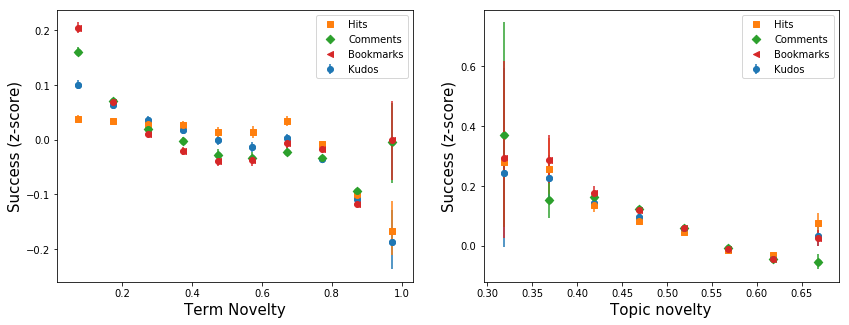

In [51]:
plt.figure(figsize=(14,5))


plt.subplot(1, 2, 1)

tfidf_kudos_x = sorted(tfidf_kudos_dict.keys())
tfidf_kudos_y = [tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_kudos_dict[j][0] - tfidf_kudos_dict[j][1] for j in tfidf_kudos_x]
upper_error = [tfidf_kudos_dict[j][2] - tfidf_kudos_dict[j][0] for j in tfidf_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_kudos_x, tfidf_kudos_y, yerr=asymmetric_error,fmt='o', label = 'Kudos')
plt.scatter(tfidf_kudos_x, tfidf_kudos_y)

tfidf_hits_x = sorted(tfidf_hits_dict.keys())
tfidf_hits_y = [tfidf_hits_dict[j][0] for j in tfidf_hits_x]
lower_error = [tfidf_hits_dict[j][0] - tfidf_hits_dict[j][1] for j in tfidf_hits_x]
upper_error = [tfidf_hits_dict[j][2] - tfidf_hits_dict[j][0] for j in tfidf_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_hits_x, tfidf_hits_y, yerr=asymmetric_error, fmt='o')
plt.scatter(tfidf_hits_x, tfidf_hits_y,marker='s', label = 'Hits')

tfidf_comments_x = sorted(tfidf_comments_dict.keys())
tfidf_comments_y = [tfidf_comments_dict[j][0] for j in tfidf_kudos_x]
lower_error = [tfidf_comments_dict[j][0] - tfidf_comments_dict[j][1] for j in tfidf_comments_x]
upper_error = [tfidf_comments_dict[j][2] - tfidf_comments_dict[j][0] for j in tfidf_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_comments_x, tfidf_comments_y, yerr=asymmetric_error, fmt='o')
plt.scatter(tfidf_comments_x, tfidf_comments_y, marker='D', label = 'Comments')

tfidf_bookmarks_x = sorted(tfidf_bookmarks_dict.keys())
tfidf_boomkarks_y = [tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
lower_error = [tfidf_bookmarks_dict[j][0] - tfidf_bookmarks_dict[j][1] for j in tfidf_bookmarks_x]
upper_error = [tfidf_bookmarks_dict[j][2] - tfidf_bookmarks_dict[j][0] for j in tfidf_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(tfidf_bookmarks_x, tfidf_boomkarks_y, yerr=asymmetric_error,fmt='o', )
plt.scatter(tfidf_bookmarks_x, tfidf_boomkarks_y, marker = '<', label = 'Bookmarks')
""
plt.legend()
plt.xlabel('Term Novelty',fontsize=15)
plt.ylabel('Success (z-score)',fontsize=15)


plt.subplot(1, 2, 2)

# for dic in [lda_kudos_dict, lda_hits_dict, lda_comments_dict, lda_bookmarks_dict]:

lda_kudos_x = sorted(lda_kudos_dict.keys())
lda_kudos_y = [lda_kudos_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_kudos_dict[j][0] - lda_kudos_dict[j][1] for j in lda_kudos_x]
upper_error = [lda_kudos_dict[j][2] - lda_kudos_dict[j][0] for j in lda_kudos_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_kudos_x, lda_kudos_y, yerr=asymmetric_error,fmt='o', label = 'Kudos')
plt.scatter(lda_kudos_x, lda_kudos_y)

lda_hits_x = sorted(lda_hits_dict.keys())
lda_hits_y = [lda_hits_dict[j][0] for j in lda_hits_x]
lower_error = [lda_hits_dict[j][0] - lda_hits_dict[j][1] for j in lda_hits_x]
upper_error = [lda_hits_dict[j][2] - lda_hits_dict[j][0] for j in lda_hits_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_hits_x, lda_hits_y, yerr=asymmetric_error, fmt='o')
plt.scatter(lda_hits_x, lda_hits_y,marker='s', label = 'Hits')

lda_comments_x = sorted(lda_comments_dict.keys())
lda_comments_y = [lda_comments_dict[j][0] for j in lda_kudos_x]
lower_error = [lda_comments_dict[j][0] - lda_comments_dict[j][1] for j in lda_comments_x]
upper_error = [lda_comments_dict[j][2] - lda_comments_dict[j][0] for j in lda_comments_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_comments_x, lda_comments_y, yerr=asymmetric_error, fmt='o')
plt.scatter(lda_comments_x, lda_comments_y, marker='D', label = 'Comments')

lda_bookmarks_x = sorted(lda_bookmarks_dict.keys())
lda_bookmarks_y = [lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
lower_error = [lda_bookmarks_dict[j][0] - lda_bookmarks_dict[j][1] for j in lda_bookmarks_x]
upper_error = [lda_bookmarks_dict[j][2] - lda_bookmarks_dict[j][0] for j in lda_bookmarks_x]
asymmetric_error = [lower_error, upper_error]
plt.errorbar(lda_bookmarks_x, lda_bookmarks_y, yerr=asymmetric_error,fmt='o', )
plt.scatter(lda_bookmarks_x, lda_bookmarks_y, marker = '<', label = 'Bookmarks')

plt.legend()
plt.xlabel('Topic novelty', fontsize = 15)
plt.ylabel('Success (z-score)', fontsize = 15)
plt.savefig('scatter_all.pdf', type='pdf')
